# Infrastructure to road network-assignment

In [12]:
%%html
<style>
table {float:left}
</style>

| Document info | |
| --- | --- | 
| Area of interest: | Singapore |
| Prepared by: | Waste Labs (wastelabs.co) |
| Prepared for: | Demonstration purposes |
| Contact: | info@wastelabs.co |

In [13]:
%reload_kedro
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False

import pandas as pd

# Extra options
# Extra options
pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import logging

logging.basicConfig(level=logging.INFO)

import importlib
import os
import sys

import geopandas as gpd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
from geopandas.tools import sjoin
from GPSOdyssey import Kepler
from IPython.display import clear_output
from ipywidgets import fixed, interact, interact_manual, interactive
from shapely import wkt

2022-04-05 23:46:23,546 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-04-05 23:46:23,618 - root - INFO - ** Kedro project Demand estimation and waste collection routing optimisation for the City of Cape Town
2022-04-05 23:46:23,619 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-04-05 23:46:23,628 - root - INFO - Registered line magic `run_viz`
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from mcarptif.osmnx_network_extract.network_code_garp import (
    NetworkCode,
    create_gdf,
    create_latlon_gdf,
    customer_network_plot,
    return_crs,
)

In [15]:
prep_network = catalog.load("road_network_simplified_24645_edges_xy_directed")
prep_network_plot = catalog.load("road_network_simplified_24645_edges_directed")

2022-04-05 23:46:23,861 - kedro.io.data_catalog - INFO - Loading data from `road_network_simplified_24645_edges_xy_directed` (GeoJSONDataSet)...
2022-04-05 23:46:24,945 - kedro.io.data_catalog - INFO - Loading data from `road_network_simplified_24645_edges_directed` (GeoJSONDataSet)...


In [16]:
producer_file

description             type          lat        lon        id  \
0     Depot 1            depot   -34.002943  18.499455    depot1   
1     Depot 2            depot   -33.985705  18.431765    depot2   
2   Offload 1  waste_treatment   -33.958541  18.457144  offload1   
3   Offload 2  waste_treatment  -34.009406,  18.456653  offload2   
4   Offload 3  waste_treatment   -33.984812  18.467095  offload3   

          category  
0            depot  
1            depot  
2  waste_treatment  
3  waste_treatment  
4  waste_treatment

In [17]:
producer_file = pd.DataFrame(context.params["infrastructure"])
producer_file = gpd.GeoDataFrame(
    producer_file,
    geometry=gpd.points_from_xy(producer_file["lon"], producer_file["lat"]), crs="EPSG:4326"
)

<AxesSubplot:>

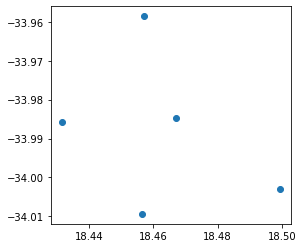

In [18]:
producer_file.plot()

In [19]:
df_producer_geo = producer_file.to_crs("EPSG:3414")

In [20]:
df_producer_geo

description             type        lat        lon        id  \
0     Depot 1            depot -34.002943  18.499455    depot1   
1     Depot 2            depot -33.985705  18.431765    depot2   
2   Offload 1  waste_treatment -33.958541  18.457144  offload1   
3   Offload 2  waste_treatment -34.009406  18.456653  offload2   
4   Offload 3  waste_treatment -33.984812  18.467095  offload3   

          category                           geometry  
0            depot  POINT (-7469440.440 -9351787.169)  
1            depot  POINT (-7474355.982 -9362248.831)  
2  waste_treatment  POINT (-7479044.359 -9357388.536)  
3  waste_treatment  POINT (-7469181.417 -9358882.663)  
4  waste_treatment  POINT (-7473712.112 -9356510.577)

### Customer locations

In [21]:
geocode_network = NetworkCode(prep_network, "SG", xy_converted=True)
geocode_network.set_arc_ids("arc_id", "geom_id_order")
geocode_network.convert_direct()

2022-04-05 23:46:46,939 - root - INFO - Convert network to x-y
2022-04-05 23:46:46,947 - root - INFO - Extracting nodes from network


/Users/ejwillemse/dev/waste_labs_dev/project_rdi_cpt/src/mcarptif/osmnx_network_extract/network_code_garp.py:65: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs=crs)


2022-04-05 23:46:47,452 - root - INFO - Removing opposing network arcs (only need one).
2022-04-05 23:46:47,472 - root - INFO - Arcs removed: 0.


In [22]:
geocode_network.add_customers(df_producer_geo)

2022-04-05 23:46:52,292 - root - INFO - Adding 5 customers.


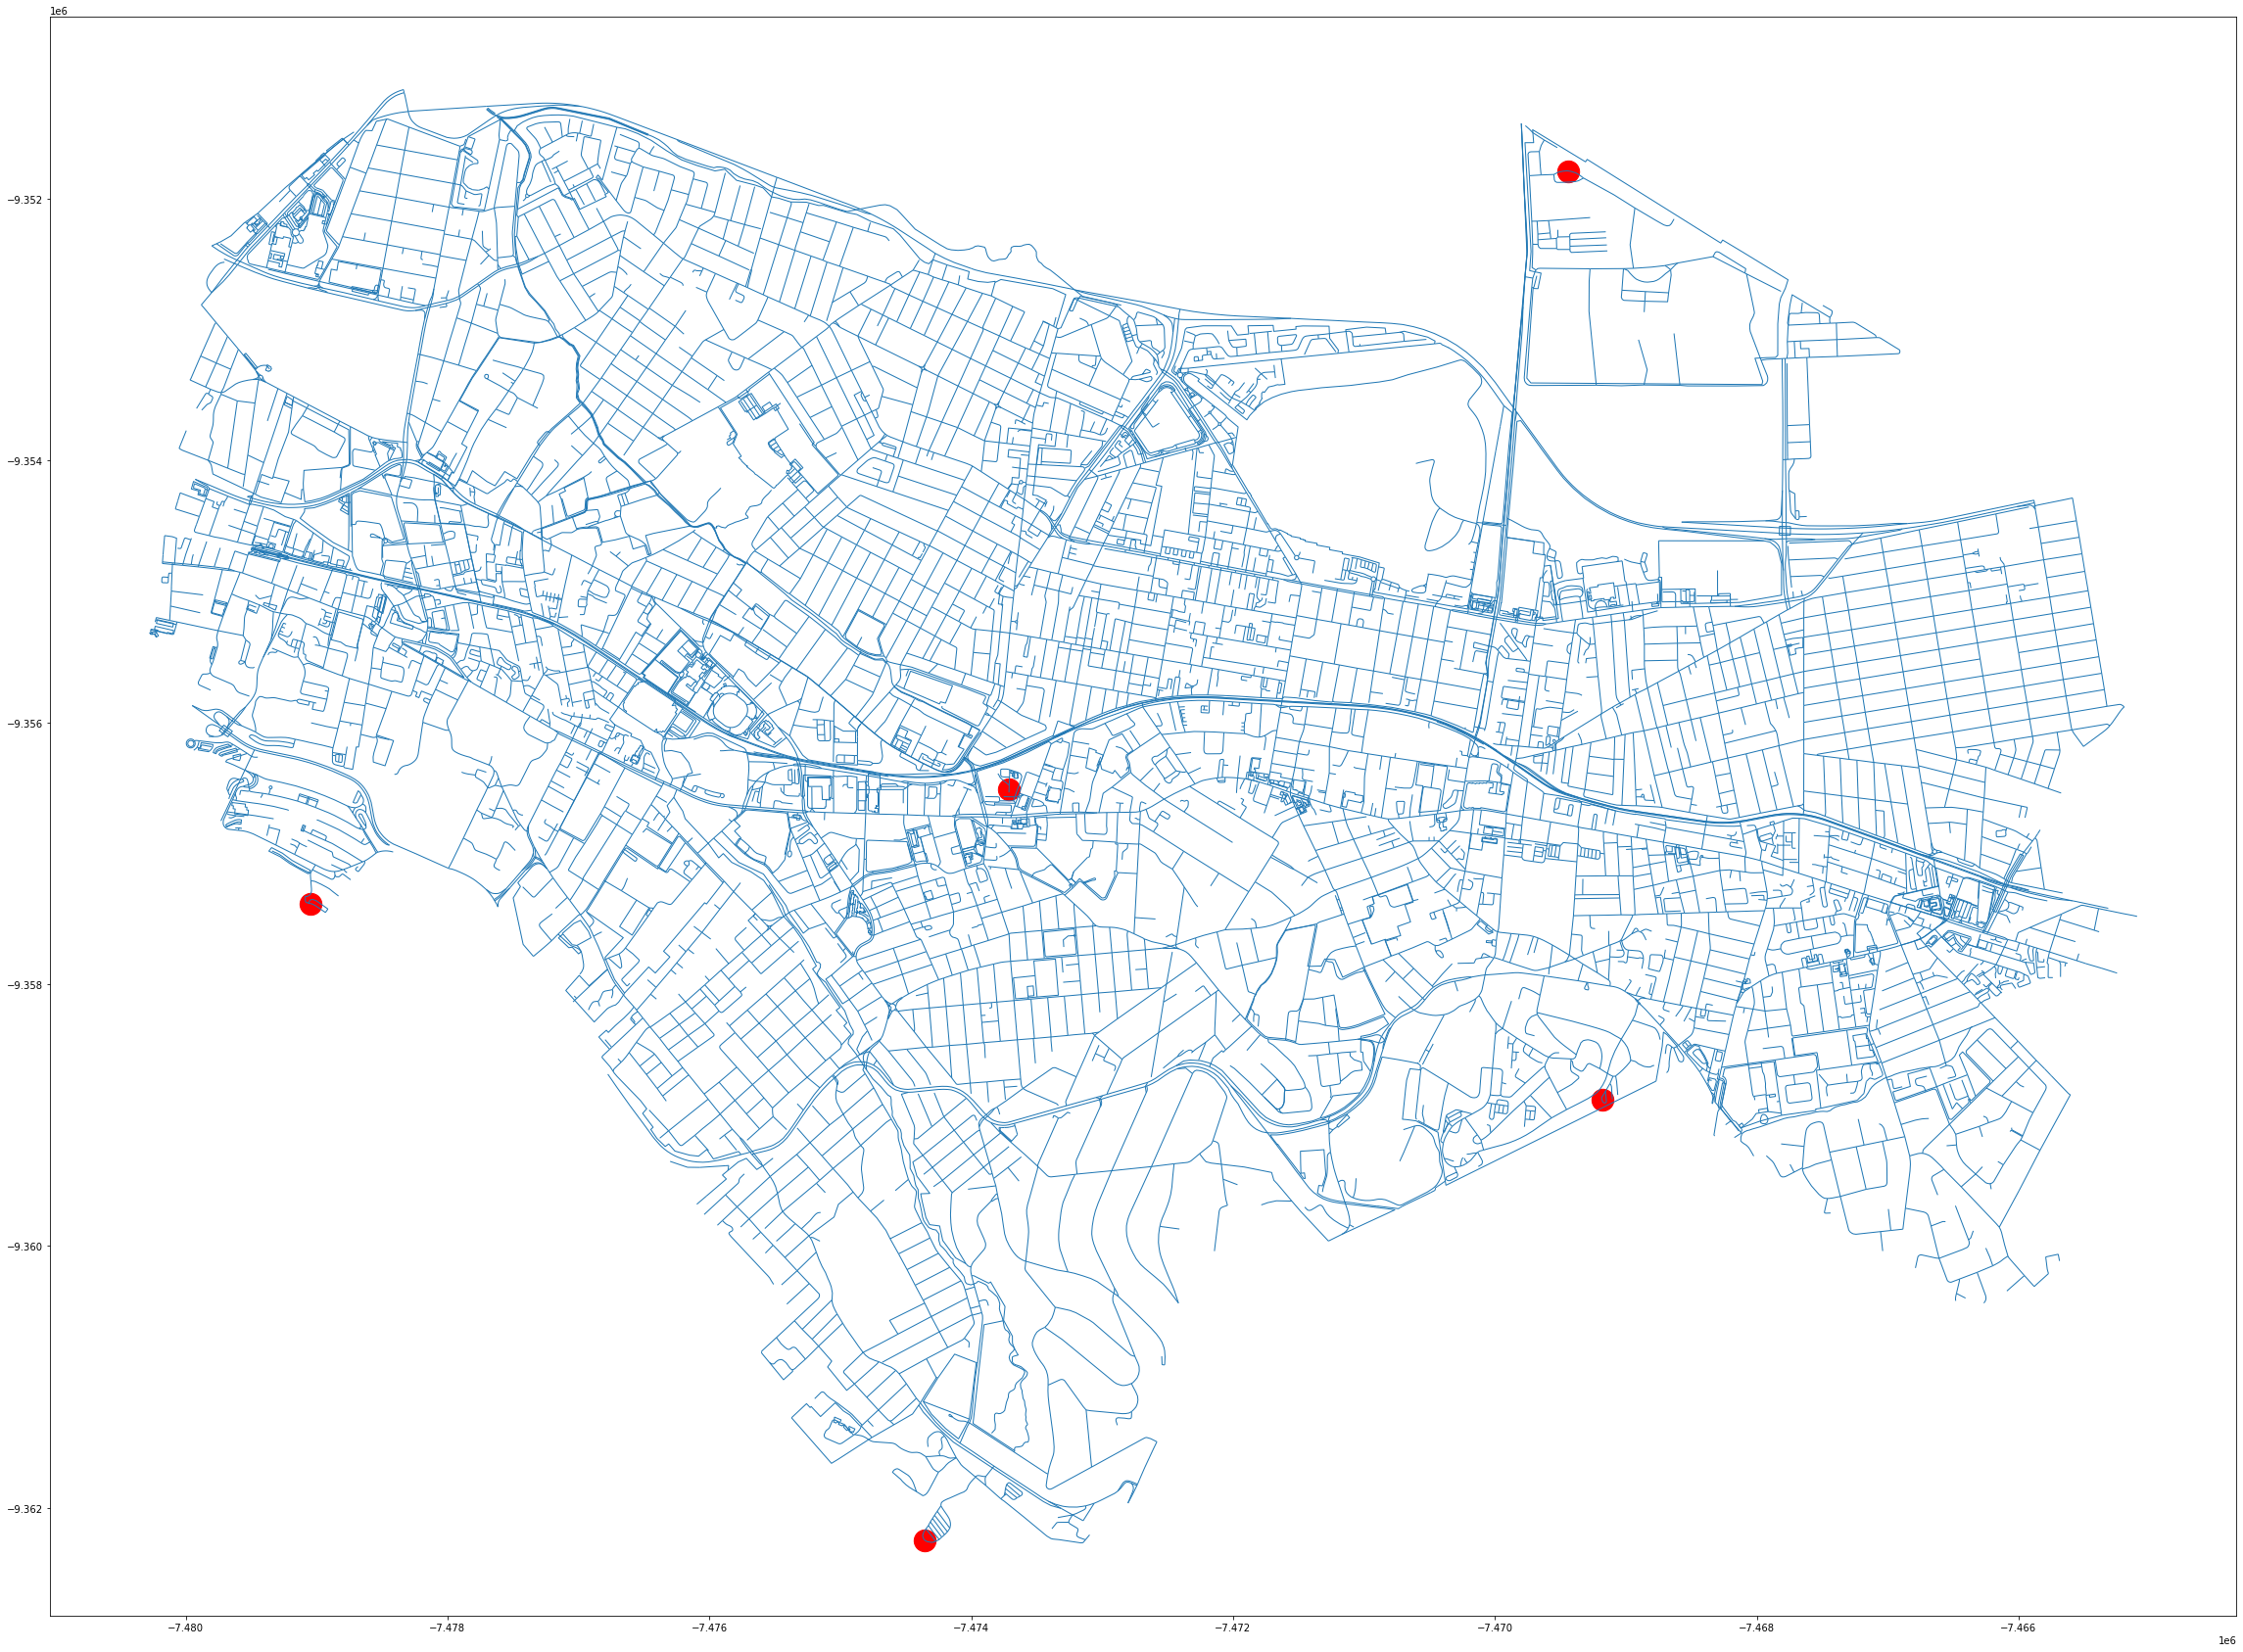

In [25]:
fig, ax = plt.subplots(figsize=(40, 40))
_ = geocode_network.df.plot(ax=ax, markersize=500, facecolor="red")
_ = geocode_network.df_network.plot(ax=ax, linewidth=1)

### Select road-types to use

In [27]:
prep_network["highway"] = prep_network["highway"].astype(str)
geocode_network.df_network["highway"] = geocode_network.df_network["highway"].astype(
    str
)

In [28]:
road_select = list(prep_network["highway"].unique())
road_select.sort()
road_select.insert(0, "ALL")

multiple_prod_select = widgets.SelectMultiple(
    options=road_select,
    description="Road type:",
    #    value = ["['service', 'residential']",
    # 'service'],
    rows=20,
    disabled=False,
)


@interact
def filter_producers(descriptions=multiple_prod_select):
    global highway_select
    highway_select = descriptions
    if "ALL" not in highway_select:
        geocode_network.filter_network(
            filter_values=list(highway_select),
        )
    else:
        geocode_network.filter_network(
            filter_values=list(prep_network["highway"].unique())
        )
    geocode_network.df_network_filter = geocode_network.df_network_filter.set_index(
        ["u", "v", "key"]
    )

/Users/ejwillemse/opt/anaconda3/envs/python_RD/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(SelectMultiple(description='Road type:', options=('ALL', 'None', 'living_street', 'motor…

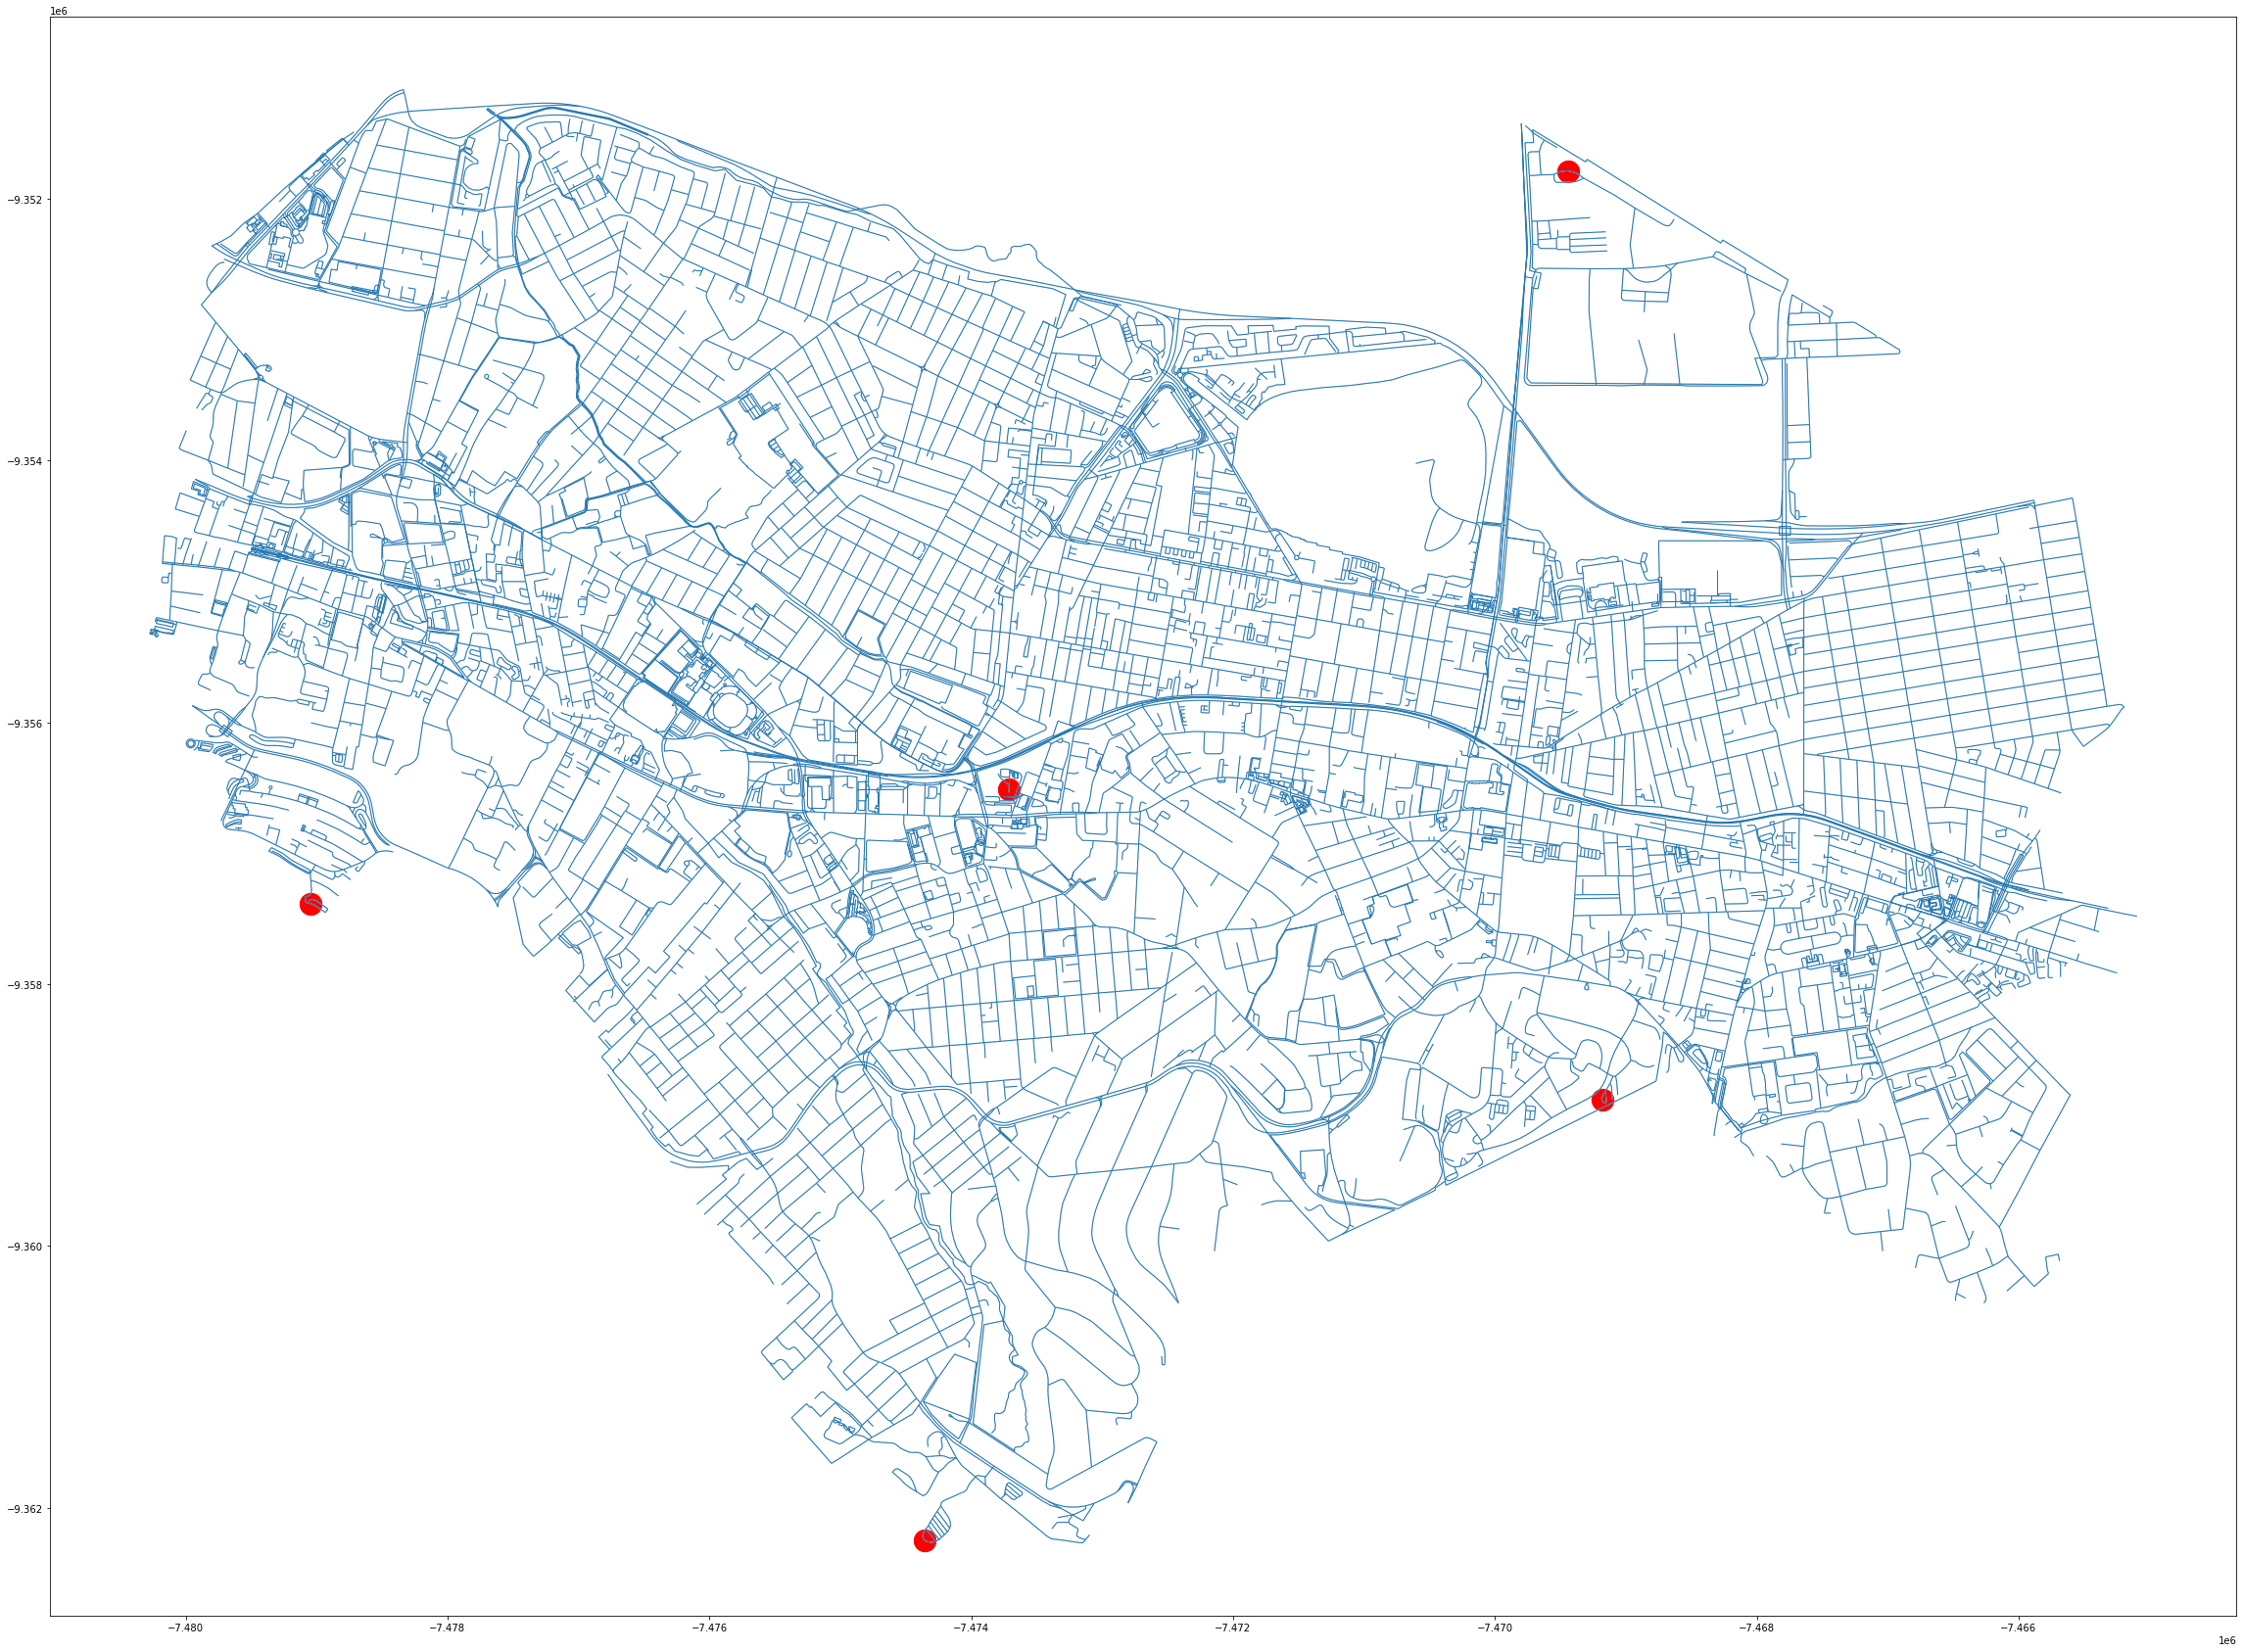

In [30]:
fig, ax = plt.subplots(figsize=(40, 40))
_ = geocode_network.df.plot(ax=ax, markersize=500, facecolor="red")
_ = geocode_network.df_network.plot(ax=ax, linewidth=1, color="lightgrey")
_ = geocode_network.df_network_filter.plot(ax=ax, linewidth=1)

In [31]:
geocode_network.find_nearest_collection_point()
geocode_network.merge_network()
geocode_network.convert_geometries_latlon()

2022-04-05 23:47:52,695 - root - INFO - Find nearest arc
2022-04-05 23:47:52,696 - root - INFO - Number of arcs 11173 number of points 5


/Users/ejwillemse/opt/anaconda3/envs/python_RD/lib/python3.8/site-packages/osmnx/distance.py:455: UserWarning: The `get_nearest_edges` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_edges` instead.
  warnings.warn(msg)


2022-04-05 23:47:57,078 - root - INFO - Find closest assigned end point
2022-04-05 23:47:57,858 - root - INFO - Find closest point on assigned arc
2022-04-05 23:47:57,898 - root - INFO - Find best collection point
2022-04-05 23:47:57,919 - root - INFO - Adding arc attributes.
2022-04-05 23:47:57,930 - root - INFO - Convert geometries to lat-lon


In [33]:
df_customer_fit = geocode_network.df_collection_points
plt_map = df_customer_fit[
    [
        "lon",
        "lat",
        "lon_collect",
        "lat_collect",
        "dist_collect",
        "arc_collect",
        "id",
        "type",
        "description",
        "highway",
        "arc_id",
        "oneway",
    ]
].copy()
plt_map = plt_map.fillna("")
kep_map = Kepler(
    data={"customer_fit": plt_map, "road_network": prep_network_plot},
    height=1000,
    config_path="config/household_road_link.json",
)

2022-04-05 23:48:28,976 - root - INFO - Start preparation of render parameters...
2022-04-05 23:48:28,978 - root - INFO - Loading map config from file: config/household_road_link.json
2022-04-05 23:48:28,983 - root - INFO - Next columns are converted to string: ['arc_id', 'id', 'oneway', 'type', 'description', 'highway']
2022-04-05 23:48:29,033 - root - INFO - Next columns are converted to string: ['arc_id', 'tunnel', 'geom_id', 'maxspeed', 'landuse', 'geom_id_inv', 'name', 'lanes', 'oneway', 'osmid', 'access', 'geom_id_order', 'junction', 'ref', 'service', 'bridge', 'highway', 'width']
2022-04-05 23:48:29,034 - root - INFO - Start renderding KeplerGL map...
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [34]:
m = kep_map.get_render()
m

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'n5f3efa', 'type': …

### Save scenario

In [35]:
%reload_kedro
catalog.save("infrastructure_sample_network_match", geocode_network.df_collection_points)

2022-04-05 23:49:43,063 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-04-05 23:49:43,137 - root - INFO - ** Kedro project Demand estimation and waste collection routing optimisation for the City of Cape Town
2022-04-05 23:49:43,138 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-04-05 23:49:43,147 - root - INFO - Registered line magic `run_viz`
2022-04-05 23:49:43,149 - kedro.io.data_catalog - INFO - Saving data to `infrastructure_sample_network_match` (CSVDataSet)...
